In [1]:
import numpy as np
import PIL.Image as Im
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.signal

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

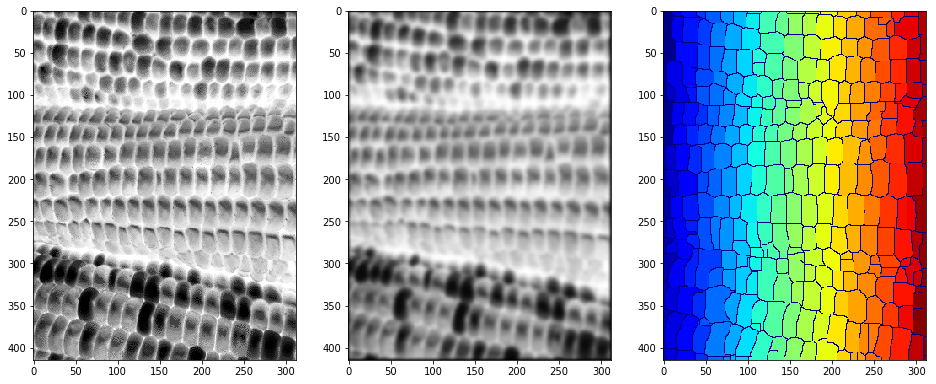

In [3]:
corn = Im.open('corn.tif')
corn_g = corn.convert("L")
corn_gi = 255 - np.array(corn_g)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(corn_gi, cmap='gray')

kernel = np.array(((1, 2, 1), (2, 4, 2), (1, 2, 1))) / 16
d = corn_gi
k = 9
for i in range(k):
    d = sp.signal.convolve2d(d, kernel, 'same')

plt.subplot(132)
plt.imshow(d, cmap='gray')

w = eng.watershed(matlab.double(d.tolist()))
plt.subplot(133)
plt.imshow(w, cmap='jet')

## Question 1
Because in watershed light pixels represnt high elevations

## Question 2
Because it's a high frequency image, a lot of changes in "elevation"

## Question 3
Around 9 times

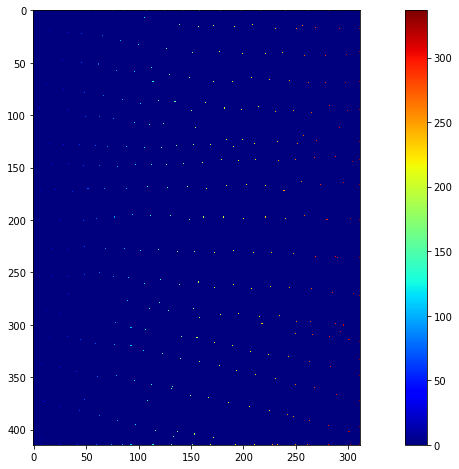

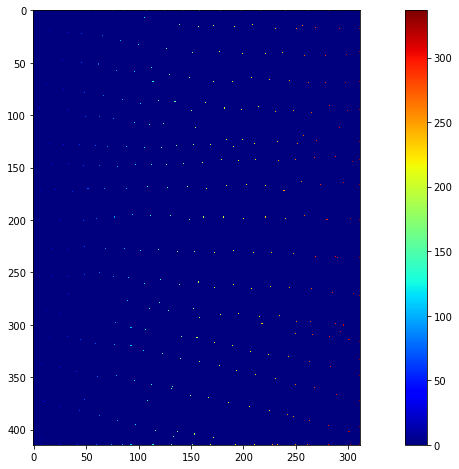

In [4]:
d_min = eng.imregionalmin(matlab.double(d.tolist()))
cc = eng.bwconncomp(d_min, float(8))
im_label = eng.labelmatrix(cc)
plt.figure(figsize=(16,8))
plt.imshow(im_label, cmap='jet')
plt.colorbar()

plt.figure(figsize=(16,8))
plt.imshow(im_label, cmap='jet')
plt.colorbar()

#print(cc)

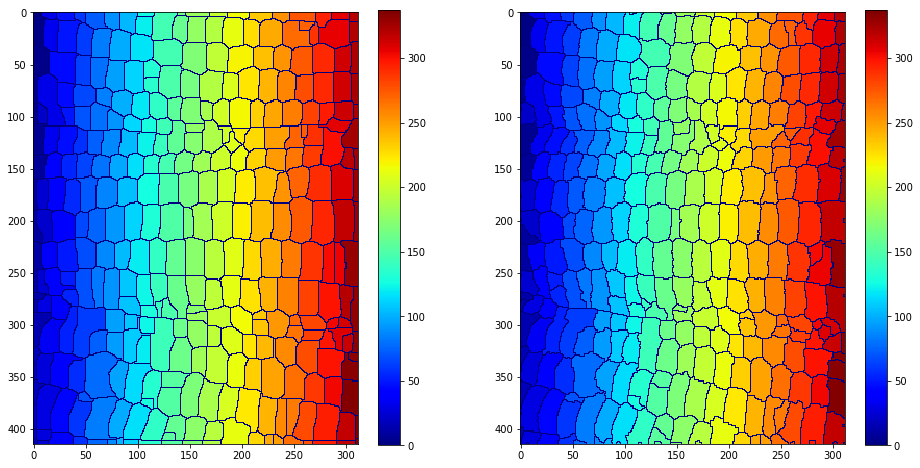

In [5]:
w1 = eng.watershed_meyer(matlab.double(d.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(w1, cmap='jet')
plt.colorbar()

w2 = eng.watershed_meyer(matlab.double(corn_gi.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc)
plt.subplot(122)
plt.imshow(w2, cmap='jet')
plt.colorbar()

## Question 4
The im2gray is more jagged, this might be closer to an actual segmentation.

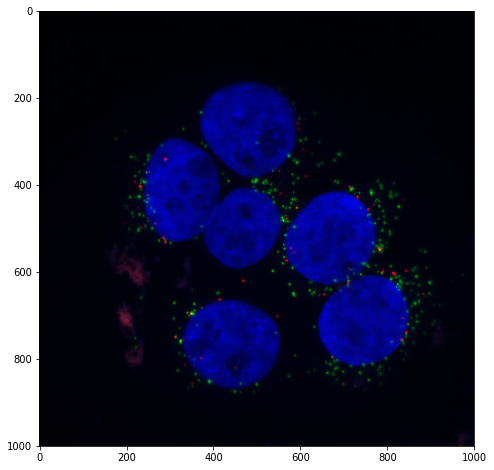

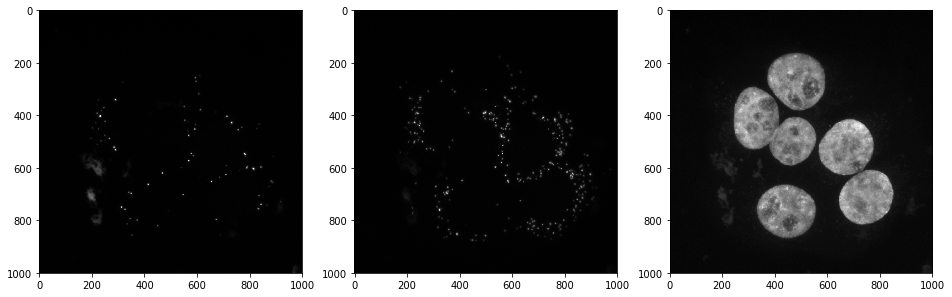

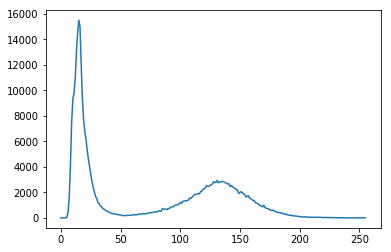

In [4]:
im1 = np.array(Im.open('lab5files/C9minpeps2.bmp'))
plt.figure(figsize=(8,8))
plt.imshow(im1)

im1r = im1[:, :, 0]
im1g = im1[:, :, 1]
im1b = im1[:, :, 2]

im1b_small = im1[200:800, 200:800, 2]
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.imshow(im1r, cmap = 'gray')

plt.subplot(132)
plt.imshow(im1g, cmap = 'gray')

plt.subplot(133)
plt.imshow(im1b, cmap = 'gray')

plt.figure()
histo = eng.hist(matlab.double(im1b_small.flatten().tolist()), matlab.double(list(range(256))))
plt.plot(range(256), histo[0]);




In [7]:
def my_0(p, t):
    res = 0
    for x in range(t):
        res += p[x] * x
    return res / sum(p[:t])

def my_1(p, t):
    res = 0
    for x in range(t-1, len(p)):
        res += p[x] * x
    return res / sum(p[t:])

total = sum(histo[0])
p = np.array(histo[0]) / total

def total_prob(p, t):
    return sum(p[0:int(round(t))] / sum(p))

def sigma_squared_0(p, t, my0):
    res = 0
    
    for x in range(t):
        res += p[x] * (x-my0)**2
    #print(res)
    return res / sum(p[:t])
    #return np.std(p[:t])

def sigma_squared_1(p, t, my1):
    res = 0
    for x in range(t, len(p)):
        res += p[x] * (x-my1)**2
    return res / sum(p[t:])

def gaussian(sigma, my, t):
    return (1/ (math.sqrt(sigma * 2 * math.pi))) * \
                math.exp(-1/2.0 * ((t - my)**2/sigma))

def least_error(histo, start_t):
    p = np.array(histo) / np.sum(histo)
    num = len(p)
    t = math.floor(start_t)
    last_t = t+1
    last_last_t = t+2
    
    while abs(last_t - t) > 0.5 and last_last_t != t:
        #t0 = t1
        
        P0 = total_prob(p, t)
        P1 = 1-P0
        
        m0 = my_0(p, t)
        m1 = my_1(p, t)
        
        sigma_0 = sigma_squared_0(p, t, m0)
        sigma_1 = sigma_squared_1(p, t, m1)
        
        #print(P0, P1, m0, m1, sigma_0, sigma_1)
        p0 = gaussian(sigma_0, m0, t)
        p1 = gaussian(sigma_1, m1, t)
        #print('{}, {}, {}, {}, {}, {}, {}, {}'.format(P0, P1, m0, m1, sigma_0, sigma_1, p0, p1))
        
        
        a = 1/((sigma_1 - sigma_0)/(sigma_0*sigma_1))
        b = 2*(-m0/sigma_0 + m1/sigma_1)
        c = -2*np.log(P0/P1) + np.log(sigma_0/sigma_1) + (m0**2)/sigma_0 - (m1**2)/sigma_1
        
        #print(a, b, c)
        r1 = -(a*b)/2 + np.sqrt((a*b/2)**2 - a*c)
        r2 = -(a*b)/2 - np.sqrt((a*b/2)**2 - a*c)
        
        last_last_t = last_t
        last_t = t
        if abs(r1 - t) < abs(r2 - t):
            t = r1
        else:
            t = r2
        
        #print('roots: {}, {}'.format(r1, r2))
        t = int(math.floor(t)) 
        
        
    return t

SE8 = np.array(((1,1,1), (1,1,1), (1,1,1)))
SE4 = np.array(((0,1,0), (1,1,1), (0,1,0)))
def dilate_oct(im, iterations):
    im_doct = scipy.ndimage.binary_dilation(im, SE4, iterations=iterations)
    im_doct = scipy.ndimage.binary_dilation(im_doct, SE8, iterations=iterations)
    return im_doct

def erode_oct(im, iterations):
    im_doct = scipy.ndimage.binary_erosion(im, SE4, iterations=iterations)
    im_doct = scipy.ndimage.binary_erosion(im_doct, SE8, iterations=iterations)
    return im_doct

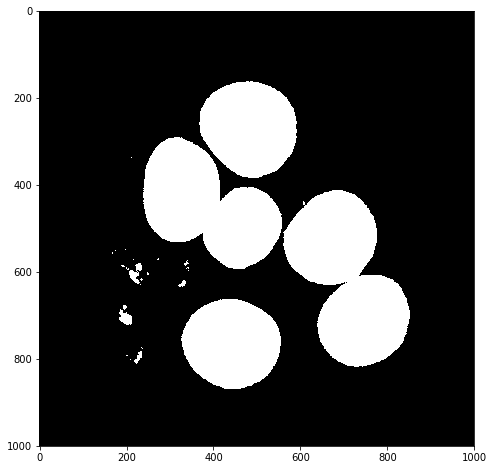

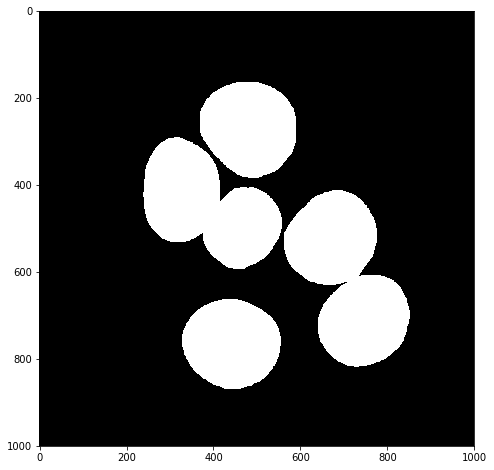

In [8]:
t = least_error(histo[0], 42)

im1bT = im1b > t
plt.figure(figsize=(8,8))
plt.imshow(im1bT, cmap='gray')

tmp = erode_oct(im1bT, 5)
im1bTmorph= dilate_oct(tmp, 5)

plt.figure(figsize=(8,8))
plt.imshow(im1bTmorph, cmap='gray')



In [9]:
d = np.array(eng.bwdist(matlab.double((~im1bTmorph).tolist())))
distance_outside = eng.bwdist(matlab.double((im1bTmorph).tolist()))

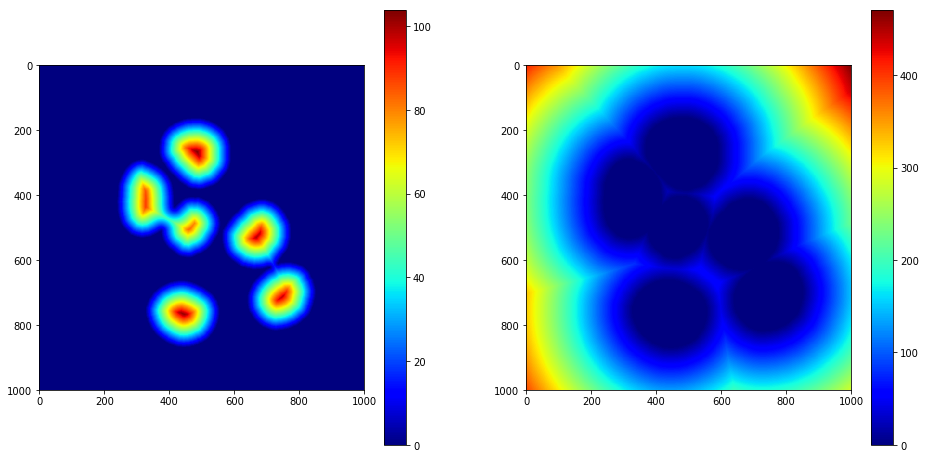

In [19]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(d, cmap = "jet")
plt.colorbar()
plt.subplot(122)
plt.imshow(distance_outside, cmap="jet")
plt.colorbar()

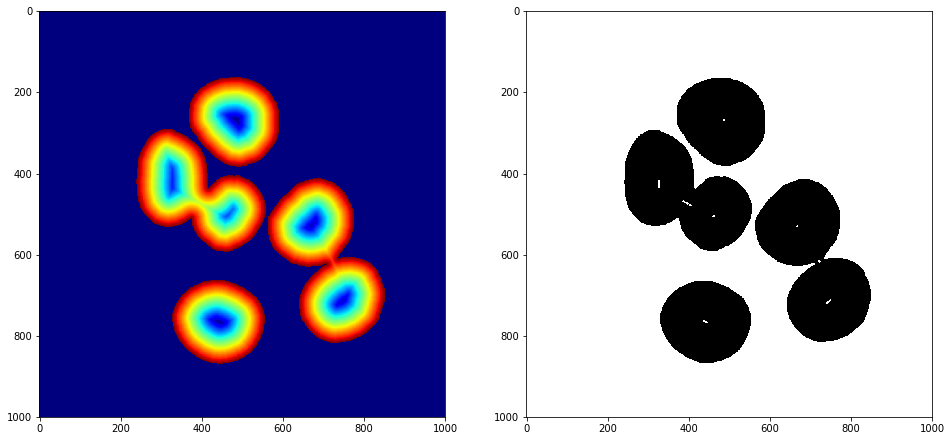

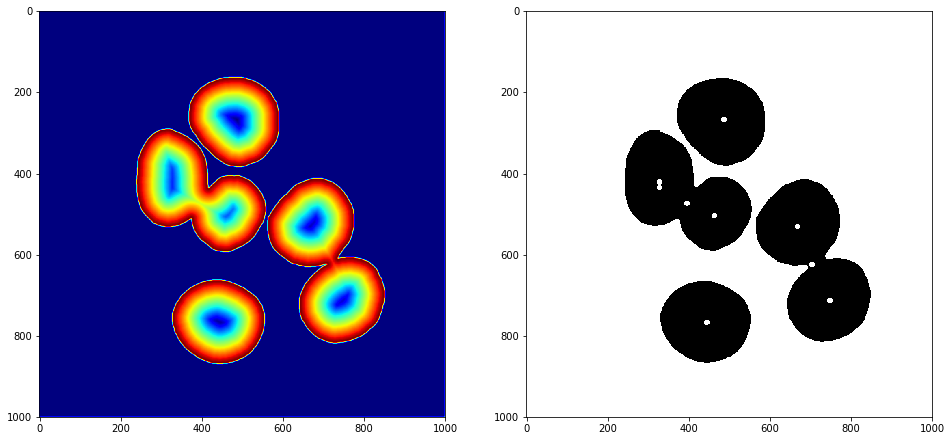

In [11]:
d_inv = -d
d_inv[~im1bTmorph] = np.min(d_inv)
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(d_inv, cmap = "jet")

d_min = np.array(eng.imregionalmin(matlab.double(d_inv.tolist())))

d_min_example = dilate_oct(d_min, 1)

plt.subplot(122)
plt.imshow(d_min_example, cmap="gray")

d_inv_convolved = d_inv
k = 3
for i in range(k):
    d_inv_convolved = sp.signal.convolve2d(d_inv_convolved, kernel, 'same')

d_min_convolved = np.array(eng.imregionalmin(matlab.double(d_inv_convolved.tolist())))

#im_label = eng.labelmatrix(cc)
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(d_inv_convolved, cmap="jet")

plt.subplot(122)
plt.imshow(dilate_oct(d_min_convolved, 3), cmap="gray")

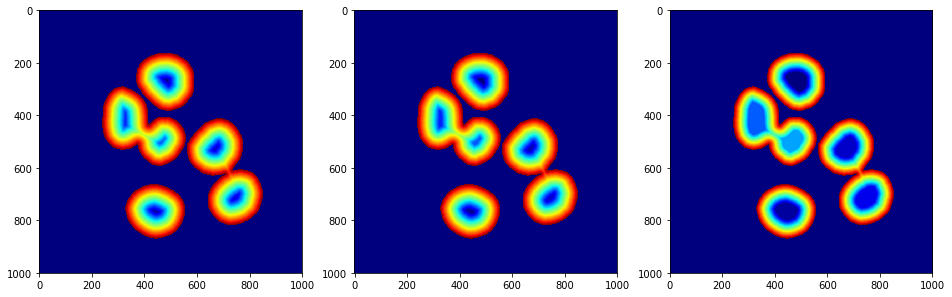

In [12]:
plt.figure(figsize=(16,16))
offset = np.min(d_inv)
d_h_inv = np.array(eng.imhmin(matlab.double((d_inv+offset).tolist()),5))
d_h_inv_extra = np.array(eng.imhmin(matlab.double((d_inv+offset).tolist()),30))

plt.subplot(131)
plt.imshow(d_inv+offset, cmap="jet")

plt.subplot(132)
plt.imshow(d_h_inv, cmap="jet")
plt.subplot(133)
plt.imshow(d_h_inv_extra, cmap="jet")

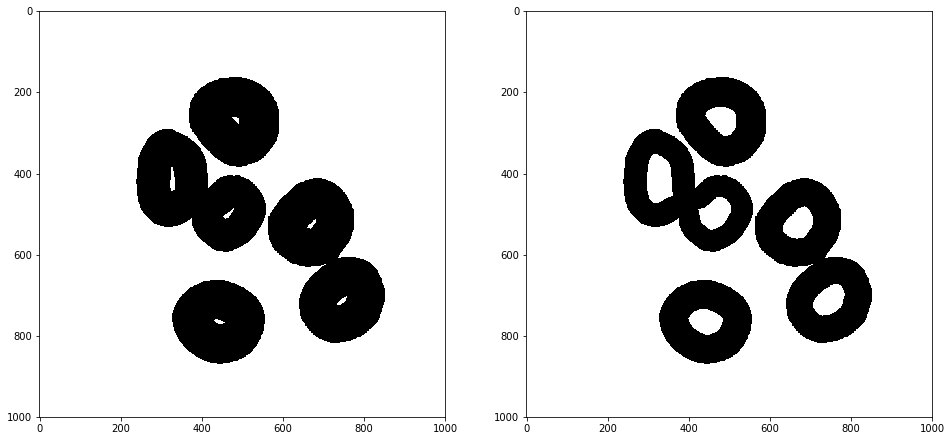

In [13]:
d_h_min = np.array(eng.imregionalmin(matlab.double(d_h_inv.tolist())))
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(d_h_min, cmap="gray")

d_h_min_extra = np.array(eng.imregionalmin(matlab.double(d_h_inv_extra.tolist())))
plt.subplot(122)
plt.imshow(d_h_min_extra, cmap="gray")

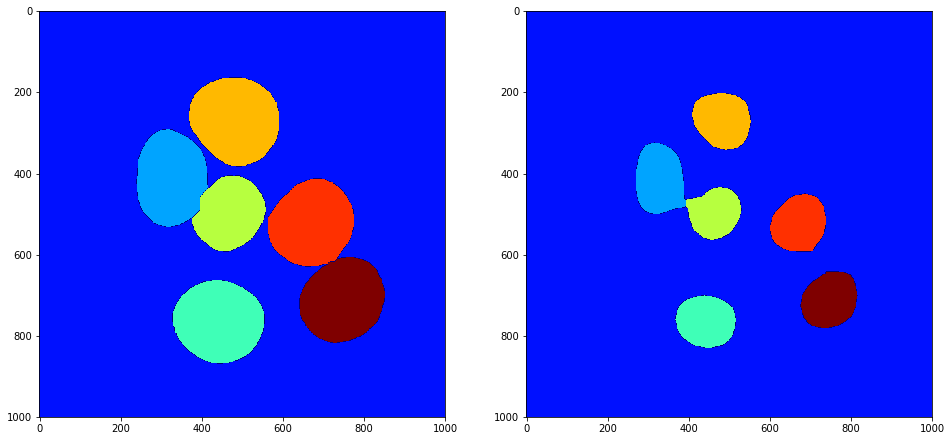

In [14]:
cc_h = eng.bwconncomp(matlab.double(d_h_min.tolist()), float(8)) 
cc_h_extra = eng.bwconncomp(matlab.double(d_h_min_extra.tolist()), float(8))

wc_h = eng.watershed_meyer(matlab.double(d_inv.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc_h)
wc_h_extra = eng.watershed_meyer(matlab.double(d_min_convolved.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc_h_extra)

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(wc_h, cmap="jet")

plt.subplot(122)
plt.imshow(wc_h_extra, cmap="jet")

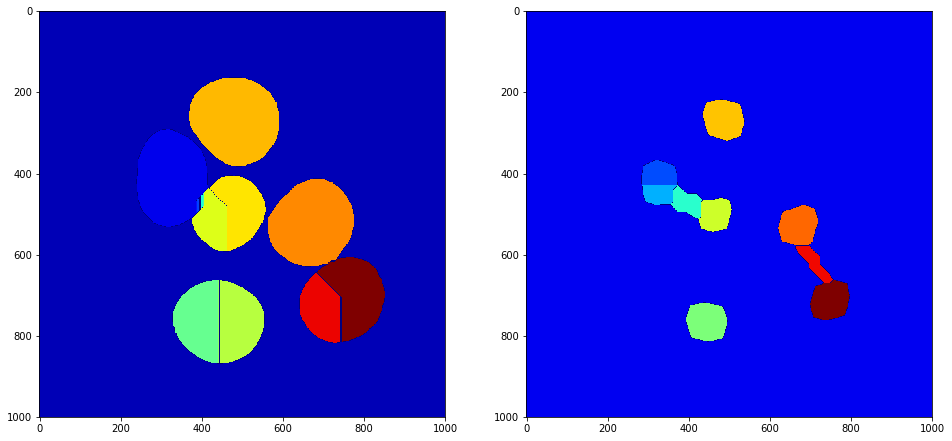

In [15]:
cc = eng.bwconncomp(matlab.double(d_min.tolist()), float(8)) 
cc_c = eng.bwconncomp(matlab.double(d_min_convolved.tolist()), float(8))

wc = eng.watershed_meyer(matlab.double(d_inv.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc)
wc_c = eng.watershed_meyer(matlab.double(d_min_convolved.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc_c)


plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(wc, cmap = "jet")

plt.subplot(122)
plt.imshow(wc_c, cmap="jet")

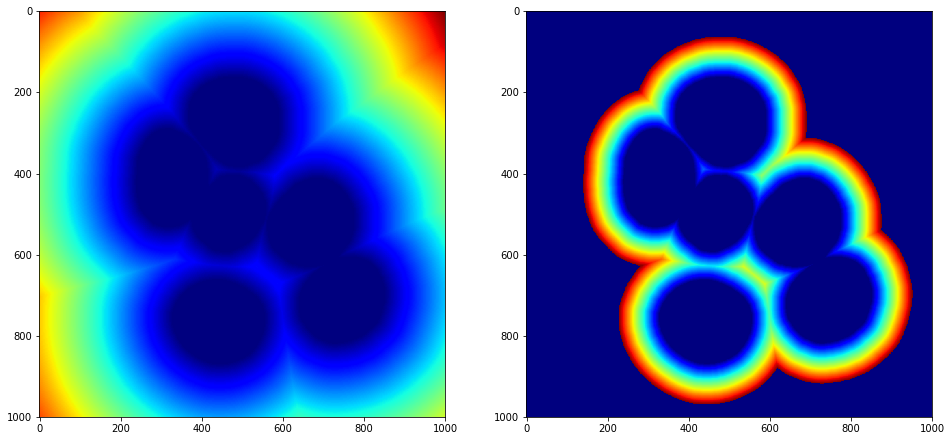

In [16]:
distance_outside_limited = np.array(distance_outside)#[distance_outside >= 100.0] = 0#np.clip(distance_outside, 0, 100)
distance_outside_limited[distance_outside_limited > 100] = 0
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(distance_outside, cmap="jet")

plt.subplot(122)
plt.imshow(distance_outside_limited, cmap="jet")

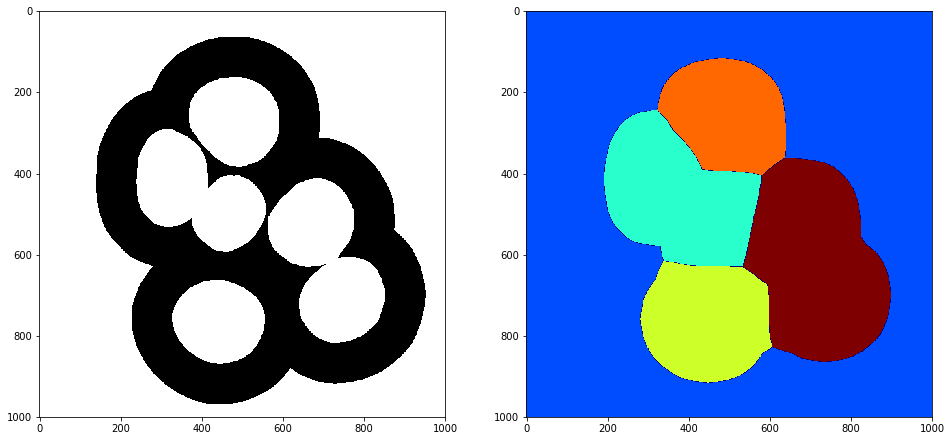

In [17]:
outside_min = np.array(eng.imregionalmin(matlab.double(distance_outside_limited.tolist())))
cc_outside = eng.bwconncomp(matlab.double(outside_min.tolist()), float(8)) 

wc_outside = eng.watershed_meyer(matlab.double(outside_min.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc_outside)

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(outside_min, cmap = "gray")

plt.subplot(122)
plt.imshow(wc_outside, cmap="jet")

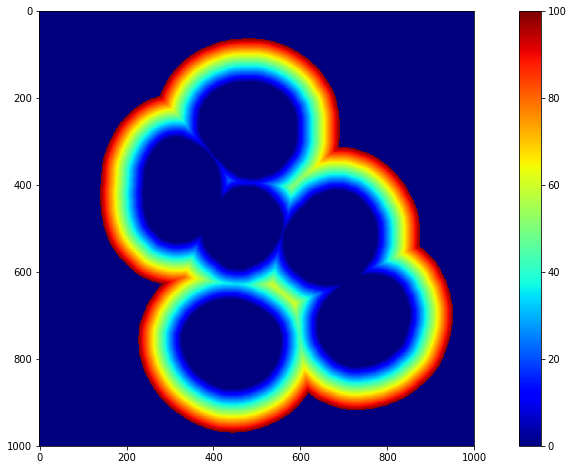

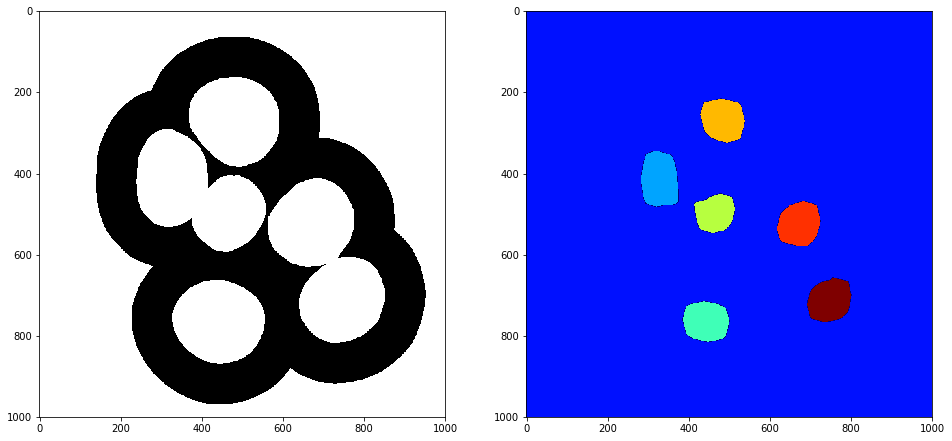

In [18]:
#distance_outside_limited[900:990, 20:100] = 100
#distance_outside_limited[920:980, 30:90] = 90
#distance_outside_limited[950:970, 40:60] = 0
plt.figure(figsize=(16,8))
plt.imshow(distance_outside_limited, cmap = "jet")
plt.colorbar()

outside_min = np.array(eng.imregionalmin(matlab.double(distance_outside_limited.tolist())))
cc_outside = eng.bwconncomp(matlab.double(outside_min.tolist()), float(8)) 

wc_outside = eng.watershed_meyer(matlab.double(outside_min.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc_h)

plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(outside_min, cmap = "gray")

plt.subplot(122)
plt.imshow(wc_outside, cmap="jet")

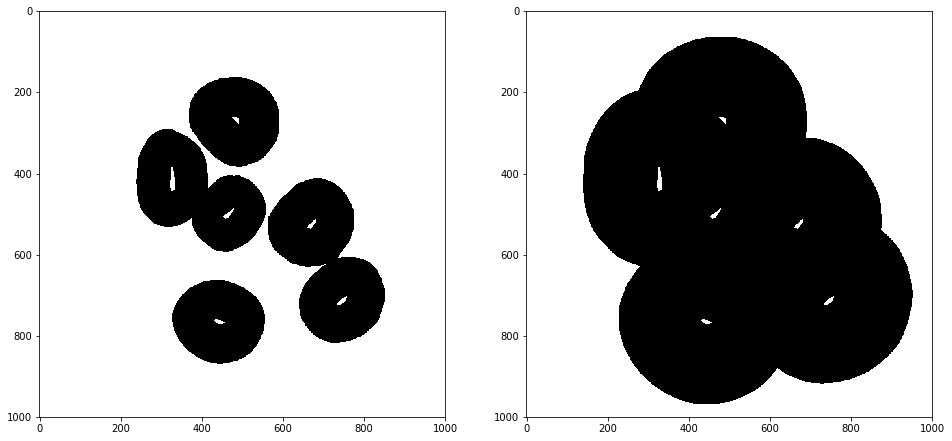

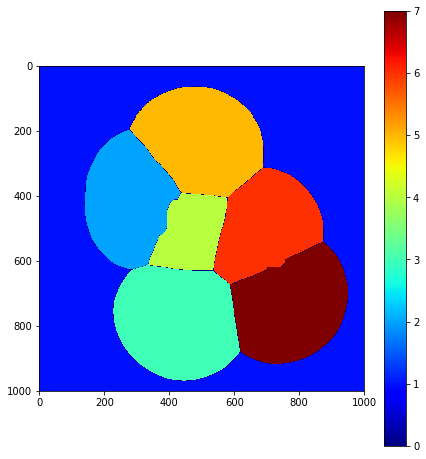

In [21]:
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(d_h_min, cmap = "gray")
#plt.colorbar()

tmp = ~(outside_min ^ d_h_min)

plt.subplot(122)
plt.imshow(tmp, cmap = "gray")
#plt.colorbar()

cc_outside = eng.bwconncomp(matlab.double(tmp.tolist()), float(8)) 
wc_outside = eng.watershed_meyer(matlab.double(distance_outside_limited.tolist()), eng.images.internal.getBinaryConnectivityMatrix(float(8)), cc_outside)

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(wc_outside, cmap = "jet")
plt.colorbar()


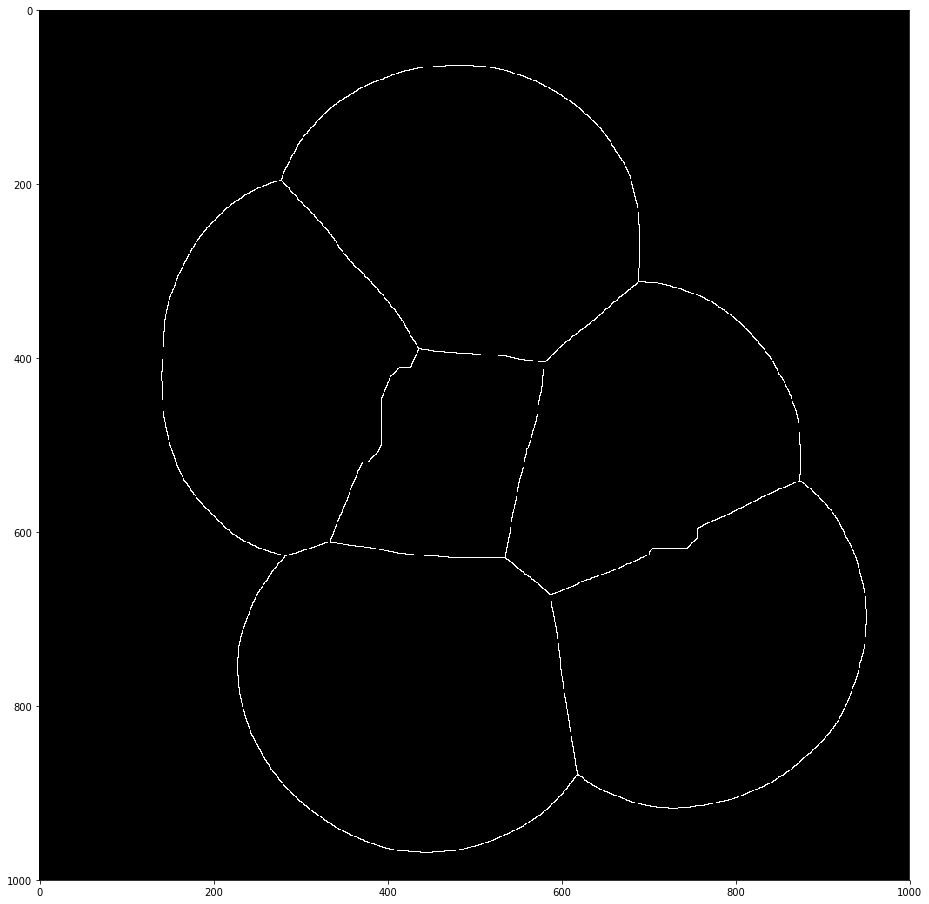

In [67]:
outline = np.array(wc_outside)
outline = outline != 0

plt.figure(figsize=(16,16))
plt.imshow(np.invert(outline), cmap="gray")


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
bool uint8


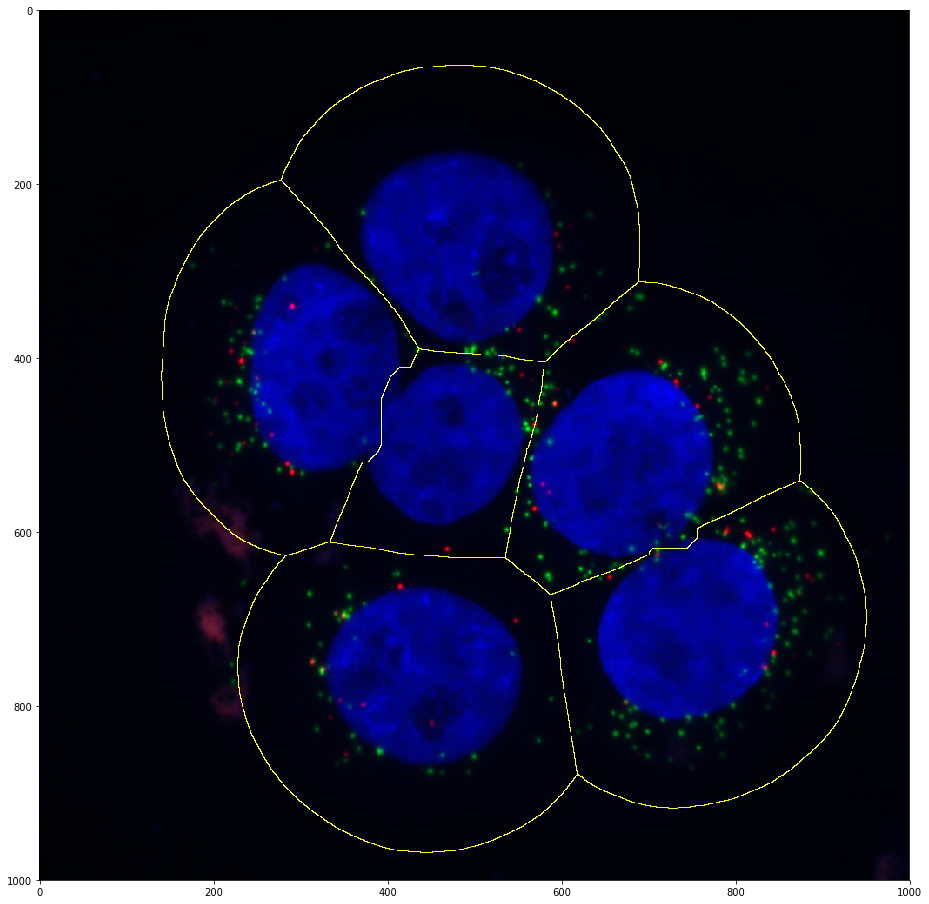

In [73]:
im_outline = np.invert(outline)
print(im_outline)
print(im_outline.dtype, im1.dtype)
im_with_outline = im1.astype(np.uint8)
im_with_outline[:, :, 0][im_outline] = 255 
im_with_outline[:, :, 1][im_outline] = 255

plt.figure(figsize=(16,16))
plt.imshow(im_with_outline)

## Question 5
I do no know

In [110]:
sobel_x = np.array(((-1, 0, 1),
                    (-2, 0, 2),
                    (-1, 0, 1)))/8
sobel_y = np.transpose(sobel_x)
tmp = sp.signal.convolve2d(-sobel_x, sobel_x)
lap = tmp + sp.signal.convolve2d(-sobel_y, sobel_y)
print(lap)

[[-0.03125 -0.0625  -0.0625  -0.0625  -0.03125]
 [-0.0625   0.       0.125    0.      -0.0625 ]
 [-0.0625   0.125    0.375    0.125   -0.0625 ]
 [-0.0625   0.       0.125    0.      -0.0625 ]
 [-0.03125 -0.0625  -0.0625  -0.0625  -0.03125]]


## Question 6
See above

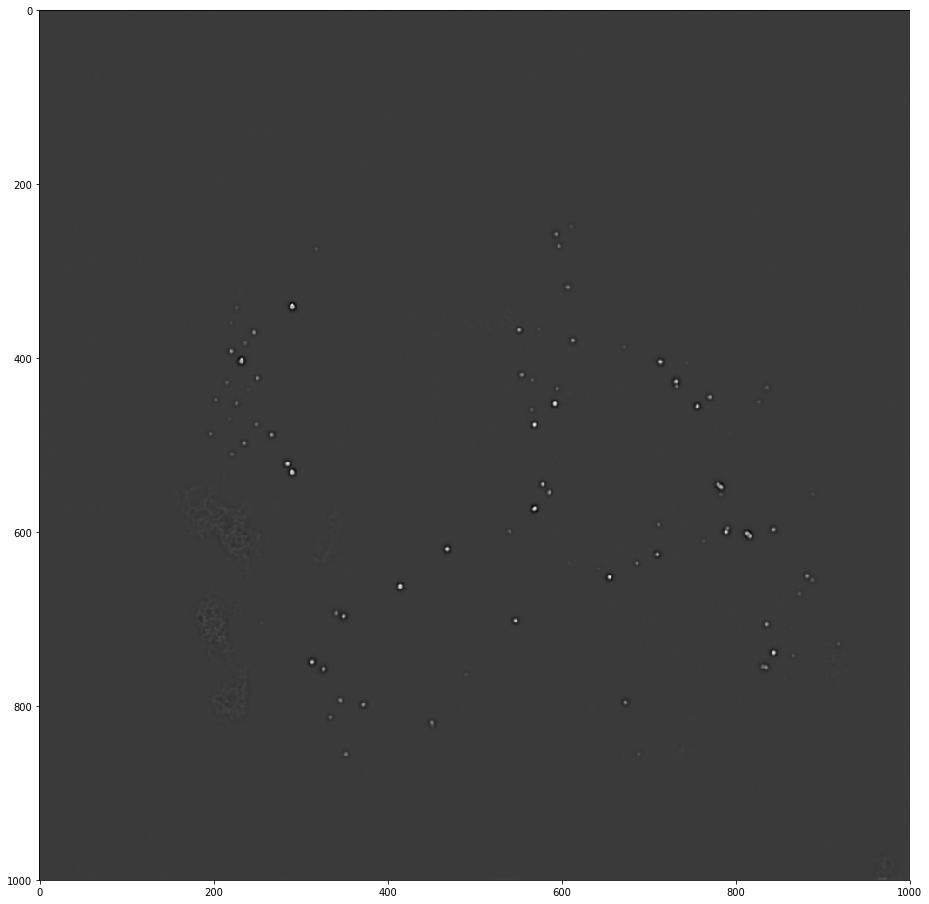

In [179]:
plt.figure(figsize=(16, 16))
im1_rc = sp.signal.convolve2d(im1[:,:,0], lap, 'same')
im1_gc = sp.signal.convolve2d(im1[:,:,1], lap, 'same')
im1_bc = sp.signal.convolve2d(im1[:,:,2], lap, 'same')


im1_c = np.stack((im1_rc, im1_gc, im1_bc), axis=2)

plt.imshow(im1_rc, cmap='gray')

(1000, 1000)
1.0


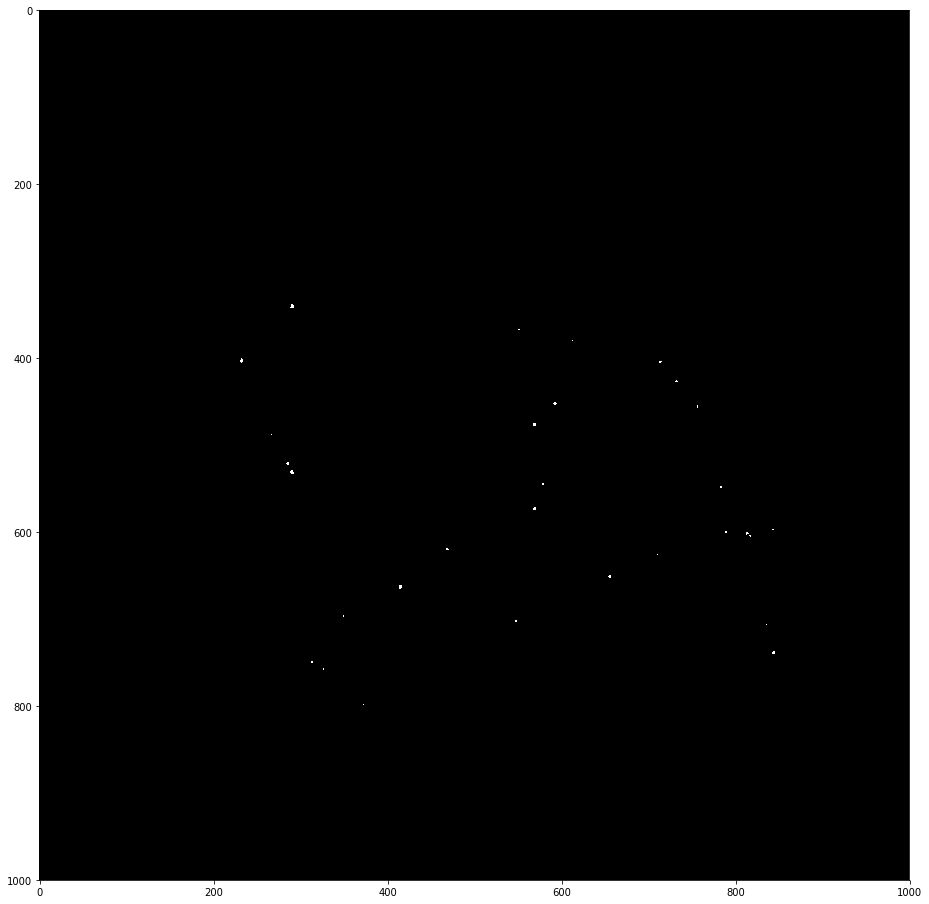

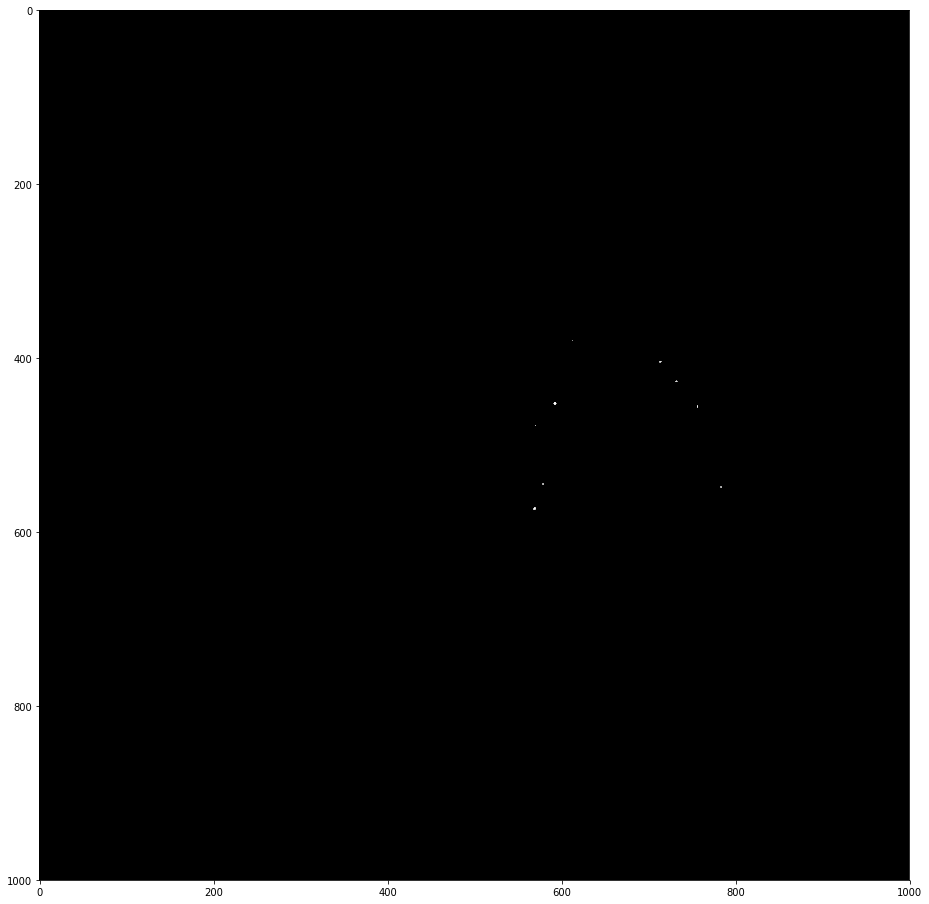

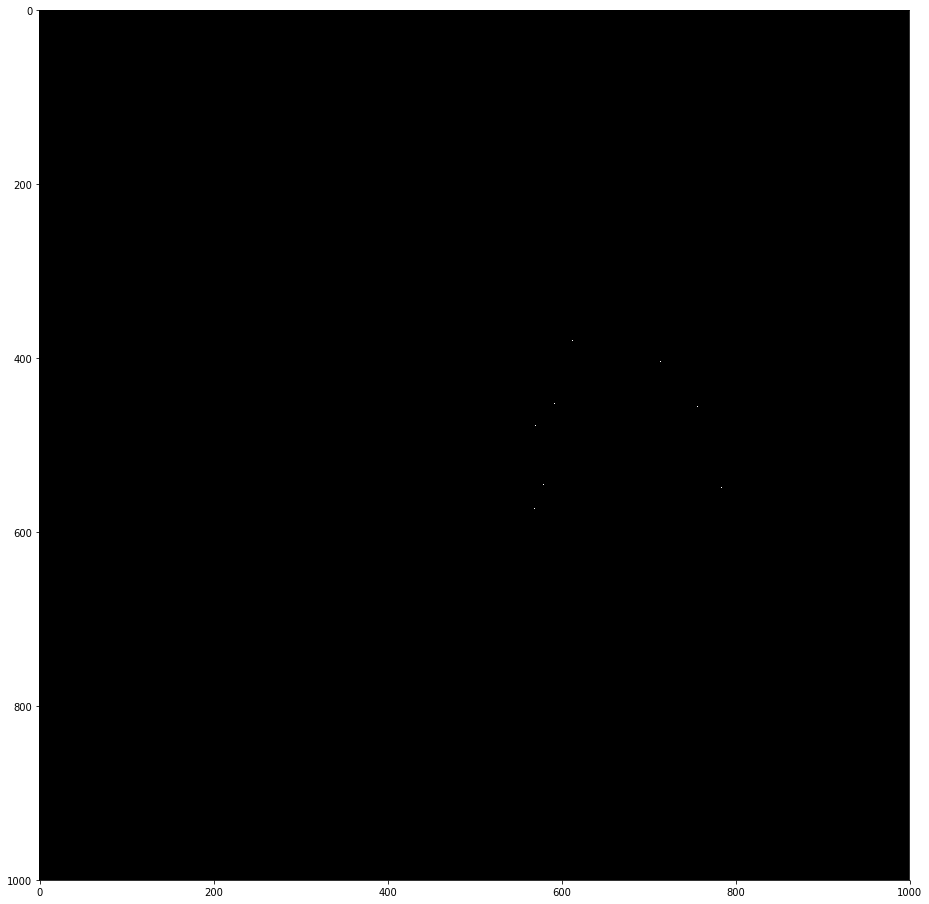

In [185]:
im1_r = (im1_rc / np.max(im1_rc))
print(im1_r.shape)
print(np.max(im1_r))
#histo = eng.hist(matlab.double(im1_r.flatten().tolist()), matlab.double(list(range(256))))
#plt.figure()
#plt.plot(range(256), histo[0]);

t = 0.5

im1_rt = im1_r > t
plt.figure(figsize=(16,16))
plt.imshow(im1_rt,cmap = 'gray')

im_rf = im1_rt * (im1_rc * (np.array(wc_outside) == 6))

#plt.figure()
#plt.imshow(wc_outside == 6, cmap='gray')

plt.figure(figsize=(16,16))
plt.imshow(im_rf,cmap = 'gray')

final = eng.imregionalmax(matlab.double(im_rf.tolist()))
plt.figure(figsize=(16,16))
plt.imshow(final, cmap='gray')

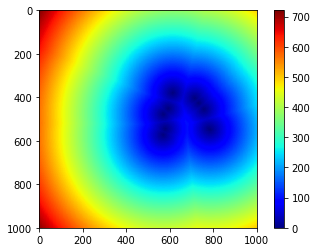

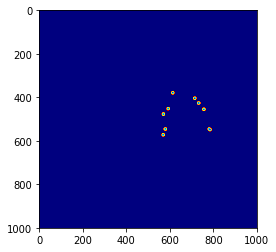

In [186]:
outside_dist = eng.bwdist(final)
plt.imshow(outside_dist, cmap='jet')
plt.colorbar()

outside_dist_t = np.array(outside_dist)
outside_dist_t[outside_dist_t > 10] = 0
plt.figure()
plt.imshow(outside_dist_t, cmap='jet')

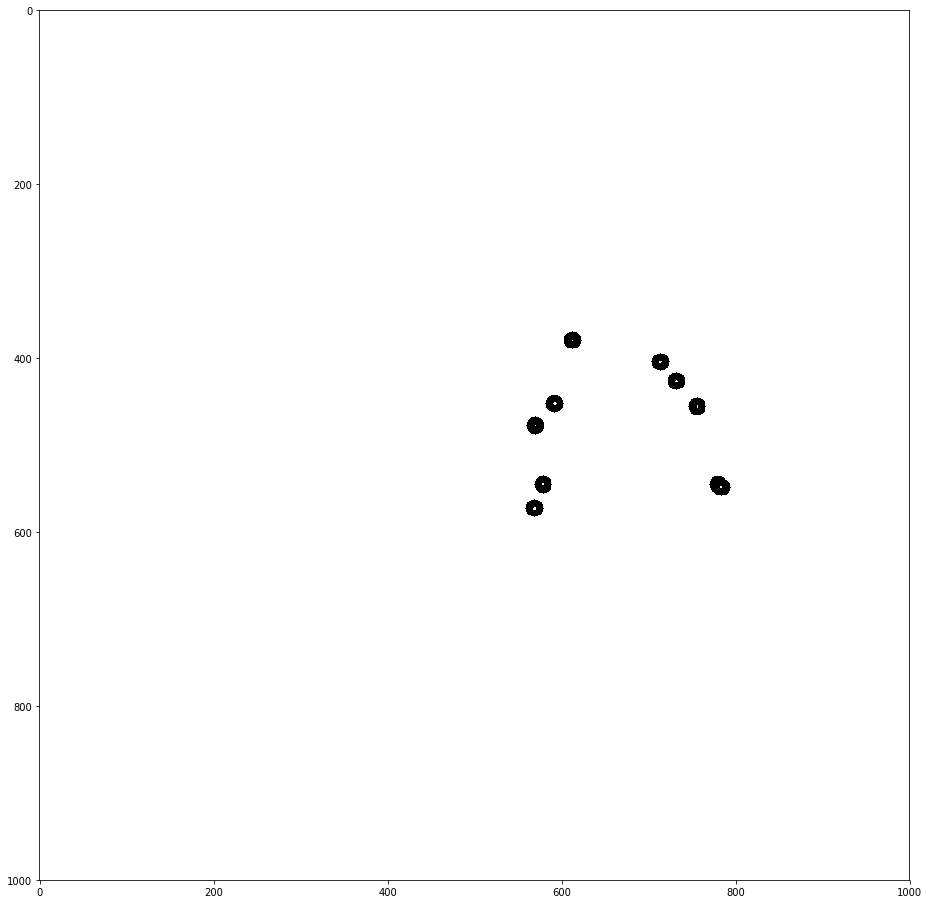

In [187]:
im_rf_t = im_rf > 0
im_blob = np.invert(im_rf_t^final + (outside_dist_t > 0))
plt.figure(figsize=(16,16))
plt.imshow(im_blob, cmap='gray')

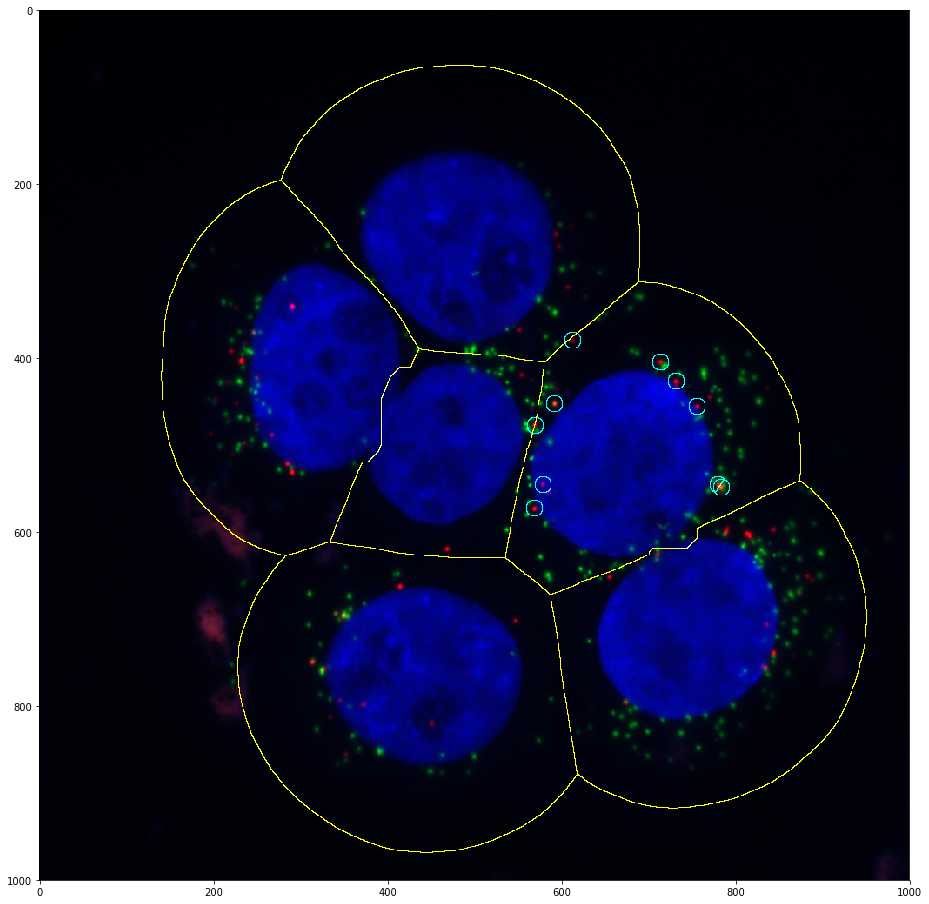

In [189]:
blob_outline = np.array(wc_blob) == 0
plt.figure(figsize=(16,16))

im_with_2_outline = im_with_outline
im_with_2_outline[:, :, 1][blob_outline] = 255
im_with_2_outline[:, :, 2][blob_outline] = 255

plt.imshow(im_with_2_outline)

## Question 8
$9$